### Analyzing the best solutions found

| Experiment ID | Min DF | Binary | Vectorizer | Method | Best k |
|---------------|--------|--------|------------|--------|--------|
| 1463          | 0.35   | True   | NCut       | NMF    | 7      |
| 26            | 0.05   | True   | Count      | LDA    | 12     |
| 24            | 0.05   | True   | Count      | NMF    | 15     |

#### Import libraries

In [1]:
# Input
# from db import PythonProblems
import io

#DB
from questions.models import Solution, Cluster
import psycopg2

# Helpers
import numpy as np
import pickle
import base64
import pandas as pd

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer

# Distance
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, pairwise_kernels

# Learning
from clustering import Clustering
from questions.sampling import get_next_sample
from analyzer import python_analyzer

# Visualization
from plot2d import Plot2D
import matplotlib.pyplot as plt
import seaborn as sns
from generate_pdf import PDFReport
import pyLDAvis.sklearn


%matplotlib inline

In [2]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__gt=last_id)
solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
print("Problems to be ignored: %d" % problems.count())

problems = Problem.objects.filter(id__lte=last_id)
# problems = Problem.objects.all()
print("Problems to be used: %d" % problems.count())

solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
# solutions_obj = Solution.objects.all().order_by('id')
print("Solutions to be used: %d" % solutions_obj.count())

docs_id = []
questions = []
solutions = []

# Fill separated structures
for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Problems to be ignored: 591
Problems to be used: 132
Solutions to be used: 54
Got 54 documents


***Limitações do parser:***

***1. Variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

***2. Não é possível processar solução sintaticamente errada. Talvez uma tokenização básica possa ajudar quando esse for o caso e já é uma indicação de que está errado.***

### Preprocessing solutions into bag of words ###

In [3]:
def create_bag_of_words(docs, vectorizer_method, binary=False, min_df=0.2):
    vectorizer = vectorizer_method(analyzer = python_analyzer,
                                   binary=binary,
                                   min_df=min_df) 
    train_data_features = vectorizer.fit_transform(docs)
    try:
        train_data_features = train_data_features.toarray()
    # It's already an array
    except AttributeError:
        pass
    return train_data_features, vectorizer, vectorizer.get_feature_names()

In [4]:
# %load vectorizer.py
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from analyzer import python_analyzer
import numpy as np


class NCutVectorizer(object):
    def __init__(self, analyzer, binary, min_df):
        self.vectorizer = CountVectorizer(analyzer = python_analyzer,
                                          binary=binary,
                                          min_df=min_df)

    def fit_transform(self, docs):
        train_data_features = self.vectorizer.fit_transform(docs)
        train_data_features = train_data_features.toarray()

        # Calculate NCut-weight
        doc_mat_norm = normalize(train_data_features)
        S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001
        D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])
        Y = np.dot(D, train_data_features.T)
        return Y.T
    
    def get_feature_names(self):
        return self.vectorizer.get_feature_names()


# Connect to DB

In [5]:
connection = psycopg2.connect(user = "machineteaching",
                                  password = "vw_$Z^vBgn?7H{z4",
                                  host = "localhost",
#                                   port = "5432",
                                  database = "machineteaching")
connection.autocommit=True
cursor = connection.cursor()

In [6]:
def get_where_items(exp_id):
    cols = ["vectorizer", "min_df", "is_binary", "distance", "method", "dataset", "k", "model", "X"]
    query = "SELECT %s from experiments_solution where experiment_id = %s" % (", ".join(cols), exp_id) 
    cursor.execute(query)
    where_items = cursor.fetchall()
    return where_items

def analyze(solutions, where_items, exp_id):
    v = eval(where_items[0][0])
    m = where_items[0][1]
    b = where_items[0][2]
    dist = where_items[0][3]
    method = where_items[0][4]
    k = where_items[0][6]
    model_db = pickle.loads(base64.b64decode(where_items[0][7]))
    X = np.asarray(where_items[0][8])

    train_data_features, vectorizer, feature_names = create_bag_of_words(solutions, v, binary=b, min_df=m)
    clustering = Clustering(train_data_features, k, metric=dist)
    clustering.seed = model_db.random_state
    
    model, document_topic, word_topic = getattr(clustering, method)()
    
    savefig='problems_20190101_%s_%s_exp_%s_%s_document_topic_distribution.png' % (method, clustering.seed, 
                                                                                   exp_id, clustering.k)
    clustering.plot_topic_distribution(title="Document distribution per topic", ylabel="Document ID", savefig=savefig)

    print("Count per class:")
    clusters = clustering.document_topic.argmax(axis=1)
    counts = np.unique(clusters, return_counts=True)
    print(counts)
    return clustering, method, feature_names, model

#### Visualization
Reduce to 2 dimensions

In [7]:
def plot_reduction(clustering, method, exp_id):
    cluster_names = ["Topic %d" % (i+1) for i in range(clustering.k)]
    doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
    doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
    handler = Plot2D(clusters=cluster_names, doc_category=doc_category, doc_id=docs_id)
    handler._generate_random_state()
    solution_sample = clustering.X

    # Reduce using PCA
    handler.reduce_pca(solution_sample)
#     print(handler.seed)
    handler.plot(show_clusters=True, savefig='problems_20190101_%s_%s_exp_%s_%s_pca.png' % (method, clustering.seed,
                                                                                         exp_id, clustering.k))

    # Reduce using SVD
    handler.reduce_svd(solution_sample)
#     print(handler.seed)
    handler.plot(show_clusters=True, savefig='problems_20190101_%s_%s_exp_%s_%s_svd.png' % (method, clustering.seed,
                                                                                         exp_id, clustering.k))

    # Reduce using TSNE
    handler.reduce_tsne(solution_sample)
#     print(handler.seed)
    handler.plot(show_clusters=True, savefig='problems_20190101_%s_%s_exp_%s_%s_tsne.png' % (method, clustering.seed,
                                                                                         exp_id, clustering.k))

    # Reduce using MDS
    handler.reduce_mds(solution_sample)
#     print(handler.seed)
    handler.plot(show_clusters=True, savefig='problems_20190101_%s_%s_exp_%s_%s_mds.png' % (method, clustering.seed,
                                                                                         exp_id, clustering.k))

    sample = handler.X
    y = clustering.document_topic.argmax(axis=1)
    return sample, y

#### Generate PDF report

In [8]:
def pdf(sample, y, clustering, method, exp_id):
    # Create X as an empty belief state (X is the machine's model of the student's distribution)
    X = np.zeros(clustering.document_topic.shape) # nS x nC
    print(X.shape)

    # Create Y as a document_topic matrix. For the first version, each document belongs to one topic
    Y_col = clustering.document_topic.argmax(axis=1) # nS x nC
    Y = np.zeros(clustering.document_topic.shape)
    for idx in range(Y.shape[0]):
        Y[idx, Y_col[idx]] = 1

    # Create W as a similarity matrix
    W = cosine_similarity(clustering.X) # nS x nS
    print(W.shape)

    with open('similarity.pkl', 'wb') as picklefile:
        pickle.dump(W, picklefile)

    # Set L as an unlabelled set
    L = []
    
    doc = PDFReport()
    
    for i in range(54):
        # Plot sample
        sample_id = get_next_sample(X, Y, W, L)

        # Print question
        problem = "Cluster: " + str(y[sample_id] + 1) + "\n" + questions[sample_id]
        solution = solutions[sample_id]

        # Plot sample
        fig = plt.figure(figsize=(9,13))

        # Get the total number of samples (nS) and total number of classes (nC). nC is not actually used.
        [nS, nC] = X.shape
        # Create the set of unlabelled samples (U)
        U = np.setdiff1d(np.arange(nS), L)

        # Plot unlabeled samples
        plt.scatter(x=sample[U,0], y=sample[U,1], s=100)

        # Color by class the ones already labeled
        if L:
            a = plt.scatter(x=sample[L,0], y=sample[L,1], c=y[L], s=100)

        # Star the queried sample
        plt.scatter(x=sample[sample_id,0], y=sample[sample_id,1], color='r', marker=r'$\star$', s=400)

        # Save figure
        plt.savefig("images/solution_%d.png" % sample_id)
        plt.close(fig)
    #     print("Question %d" % sample_id)

        # Print question
    #     problem = questions[sample_id]
    #     solution = solutions[sample_id]

        # Suppose that the student gets it correctly
        # Update X matrix
        X[sample_id] = Y[sample_id]
        L.append(sample_id)
        doc.append_solution(sample_id, problem, solution)
    #     print(X)

    doc.generate_tex("problems_20190101_%s_%s_exp_%s_%s" % (method, clustering.seed, 
                                                                    exp_id, clustering.k))

#### Words per topic

In [9]:
def normalize_per_row(matrix):
    row_sums = matrix.sum(axis=0)
    matrix_norm = matrix / row_sums[np.newaxis, :]
    return matrix_norm

def sort_distribution(df, columns, MIN_PROB=0.3):
    ids = []

    for col in columns:
        ids = ids + df[df[col] > MIN_PROB].sort_values([col], ascending=False).index.tolist()
    
    for col in columns:
        ids = ids + df.sort_values([col], ascending=False).index.tolist()

    index = df.loc[ids].index.drop_duplicates()
    df_sorted = df.loc[index]
    return df_sorted

def plot_words_per_topic(clustering, feature_names, exp_id, topics=None, size=200, figsize=(8,18), cutoff=False, 
                         ylabel=True, mark_exclusive=False):
    # word_topic_norm = normalize_per_row(word_topic)
    
    x = ["Topic %d" % (idx+1) for idx in range(clustering.document_topic.shape[1])]
    y = feature_names
    word_topic_df = pd.DataFrame(clustering.word_topic, index=y, columns=x)
    if topics:
        x = ["Topic %d" % (idx+1) for idx in topics]
        word_topic_df = word_topic_df[x]
    
    # word_topic_df = pd.DataFrame(word_topic_norm, index=y, columns=x)
    
    avg_weight = np.percentile(clustering.word_topic, 75)
    word_topic_df = sort_distribution(word_topic_df, x, MIN_PROB=avg_weight)
    
    if cutoff:
        word_topic_df['keep'] = word_topic_df.apply(lambda row: not all([(x < 1) for x in row]), axis = 1)
        word_topic_df = word_topic_df[word_topic_df['keep'] == True]
        word_topic_df.drop('keep', inplace=True, axis=1)
        
    plt.figure(figsize=figsize)

    points = word_topic_df.values
    cols = word_topic_df.columns
    rows = word_topic_df.index

    plt.xticks(range(0,len(cols)), cols, fontsize=16)
    if ylabel:
        plt.yticks(range(0,len(rows)), rows, fontsize=18)
    else:
        plt.yticks(range(0,len(rows)), '')
        
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        bottom=False,      # ticks along the bottom edge are off
        top=True,         # ticks along the top edge are off
        labelbottom=False,
        labeltop=True)
    plt.grid(alpha=0.3)

    for x_item in range(len(cols)):
        for y_item in range(len(rows)): 
            
            if points[y_item, x_item] > avg_weight:
                
                # Get terms that are exclusive for the given topic
                exclusive = []
                for x_item_comp in range(len(cols)):
                    if x_item != x_item_comp and points[y_item, x_item_comp] <= avg_weight:
                        exclusive.append('g')       
                if mark_exclusive and len(exclusive) == (len(cols)-1):
                    c = 'g'
                else:
                    c = 'r'
                
            else:
                c = 'b'
            plt.scatter(x_item, y_item, s=points[y_item, x_item]*size, c=c)

    plt.gca().invert_yaxis()
    if mark_exclusive:
        plt.savefig('images/problems_20190101_%s_%s_exp_%s_word_topic_exclusive.png' % (method, clustering.seed, exp_id))
    else:
        plt.savefig('images/problems_20190101_%s_%s_exp_%s_word_topic.png' % (method, clustering.seed, exp_id))
    plt.show()

#### pyLDAvis

In [10]:
def LDAvis(solutions, where_items, model, R=0):
    v = eval(where_items[0][0])
    m = where_items[0][1]
    b = where_items[0][2]
    dist = where_items[0][3]
    method = where_items[0][4]
    k = where_items[0][6]
    model_db = pickle.loads(base64.b64decode(where_items[0][7]))
    X = np.asarray(where_items[0][8])

    vectorizer = CountVectorizer(analyzer = python_analyzer,
                                 binary=b,
                                 min_df=m)
    train_data_features = vectorizer.fit_transform(solutions)
 
    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(model, train_data_features, vectorizer, mds='pcoa', sort_topics=False, R=R)
    return panel

# Experiment 1463

- Min DF: 0.35
- Binary: True
- Vectorizer: NCut
- Method: NMF
- Best k: 7

Conditions
('NCutVectorizer', 0.35, True, 'euclidean', 'nmf', 'solution_all', 7)


/home/lmoraes/miniconda/envs/machine_teaching/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator NMF from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


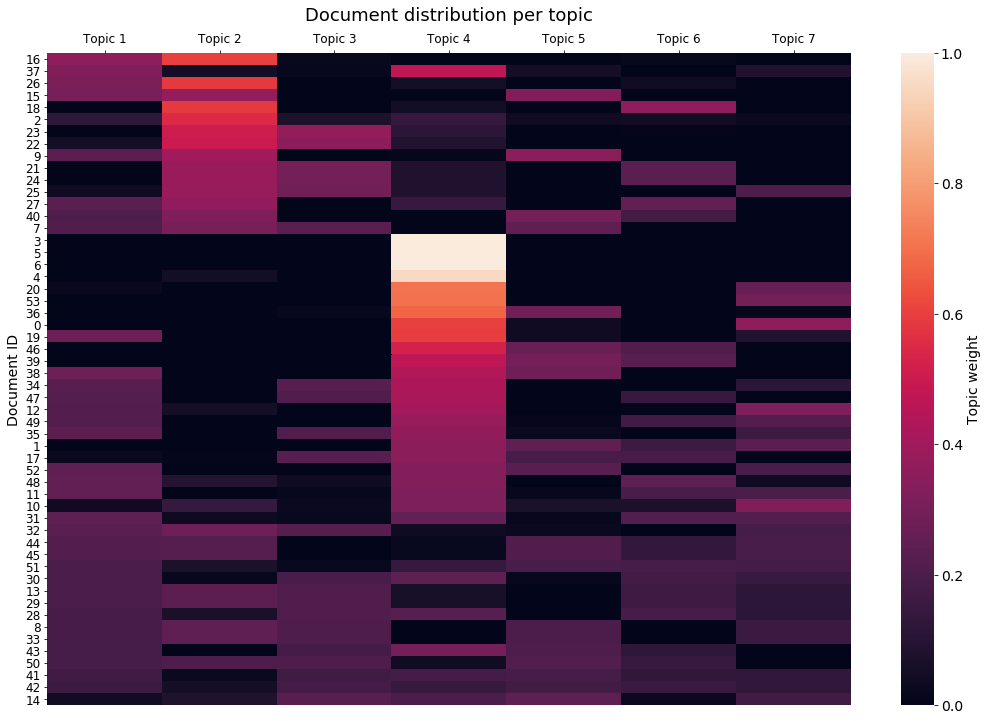

Count per class:
(array([0, 1, 2, 3, 4, 6]), array([ 1, 21,  1, 27,  3,  1]))
Number of terms: 23


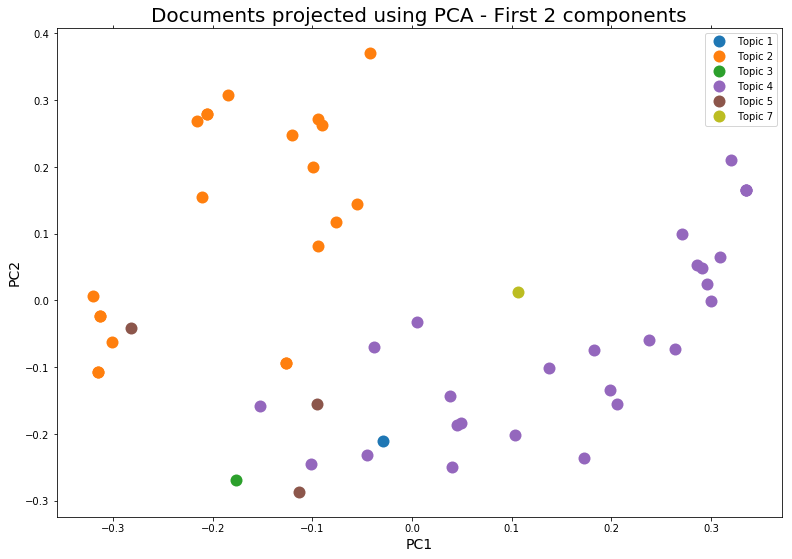

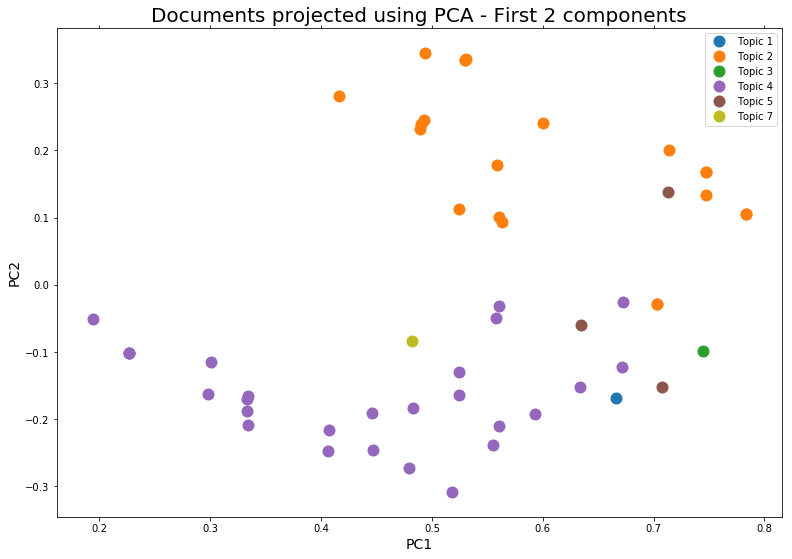

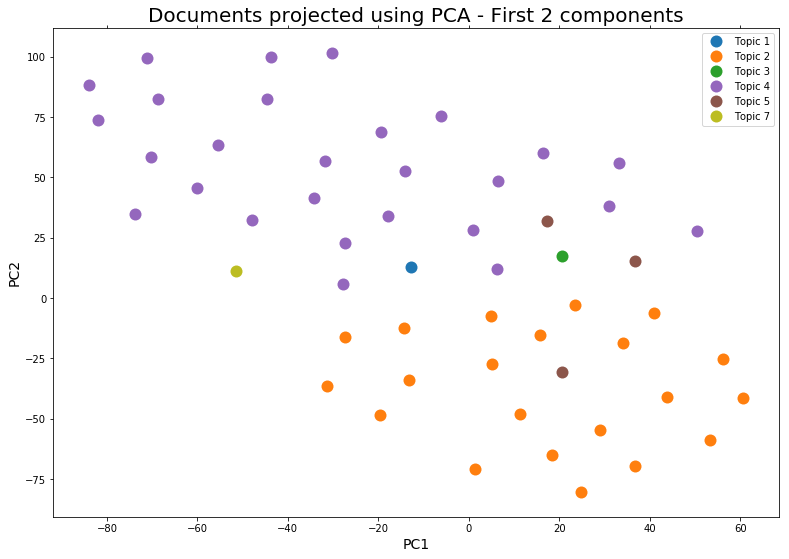

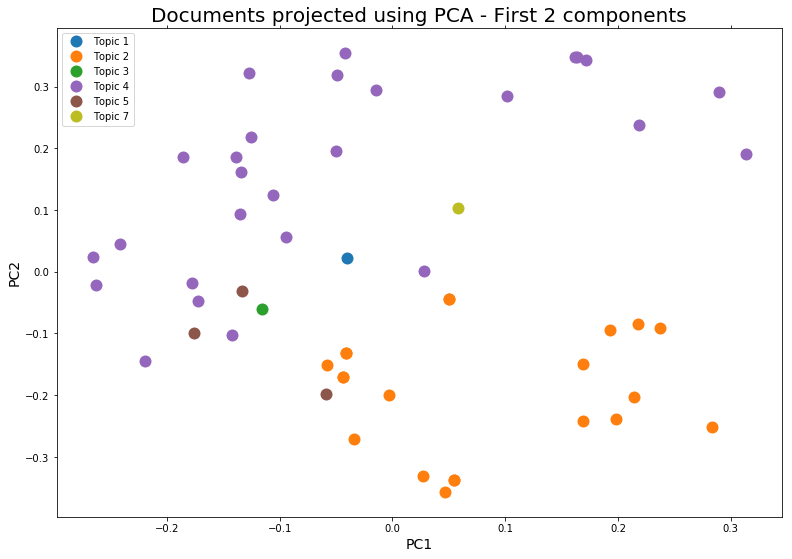

(54, 7)
(54, 54)


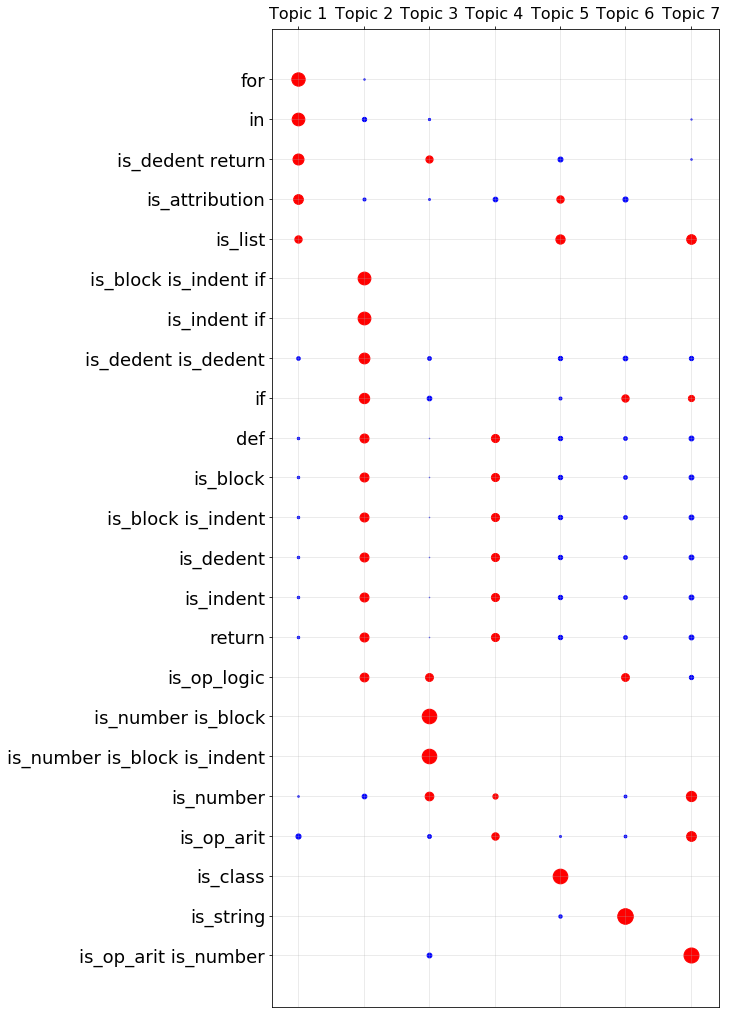

/home/lmoraes/miniconda/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/lmoraes/miniconda/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/lmoraes/miniconda/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      15.118723        1       1 -0.071854  0.327351
1      14.476589        1       2  0.119143 -0.146770
2       9.086329        1       3 -0.387049 -0.092008
3      36.379868        1       4  0.185576 -0.052236
4       8.214074        1       5  0.128053  0.163631
5       8.165775        1       6  0.055554 -0.138232
6       8.558643        1       7 -0.029423 -0.061736, topic_info=Empty DataFrame
Columns: [Category, Freq, Term, Total, loglift, logprob]
Index: [], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=0, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

In [11]:
# Get experiment conditions
exp_id = 1463
where_items = get_where_items(exp_id)
print("Conditions")
print(where_items[0][0:7])

clustering, method, feature_names, model = analyze(solutions, where_items, exp_id)
print("Number of terms: %d" % clustering.X.shape[1])
sample, y = plot_reduction(clustering, method, exp_id)
pdf(sample, y, clustering, method, exp_id)
# plot_words_per_topic(clustering, feature_names, exp_id, size=200, figsize=(12,18))
plot_words_per_topic(clustering, feature_names, exp_id, size=200)
panel = LDAvis(solutions, where_items, model)
panel

# Experiment 26

- Min DF: 0.05
- Binary: True
- Vectorizer: Count
- Method: LDA
- Best k: 12

Conditions
('CountVectorizer', 0.05, True, 'euclidean', 'lda', 'solution_all', 12)


/home/lmoraes/miniconda/envs/machine_teaching/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


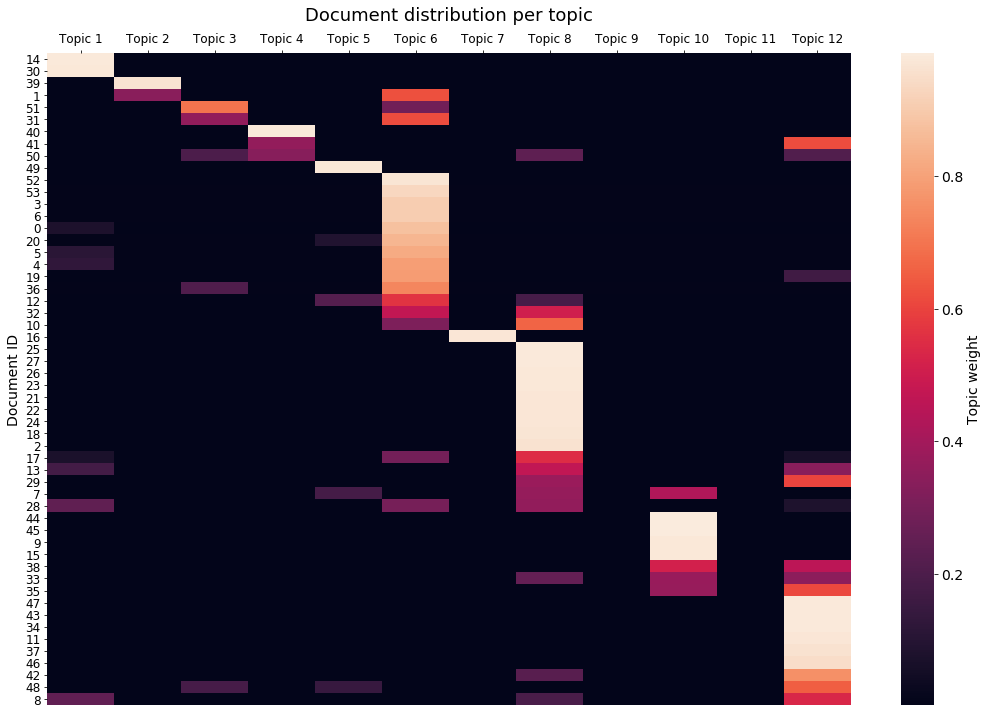

Count per class:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11]), array([ 2,  1,  1,  2,  1, 13,  1, 14,  7, 12]))
Number of terms: 236


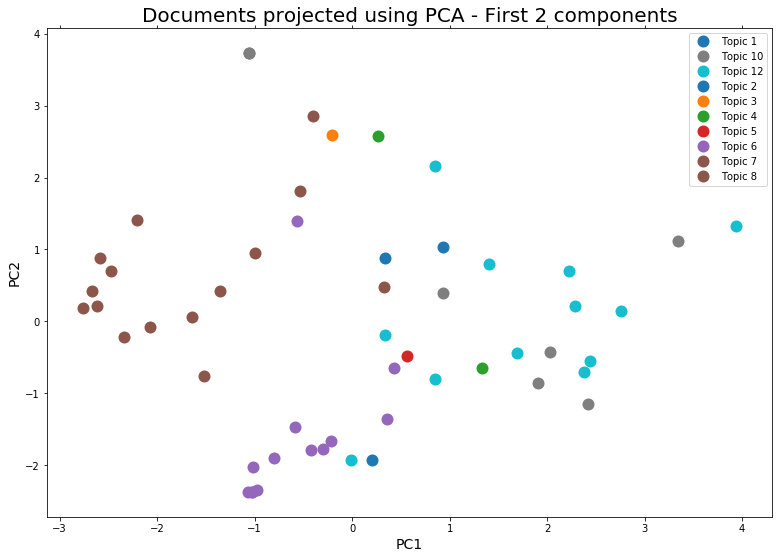

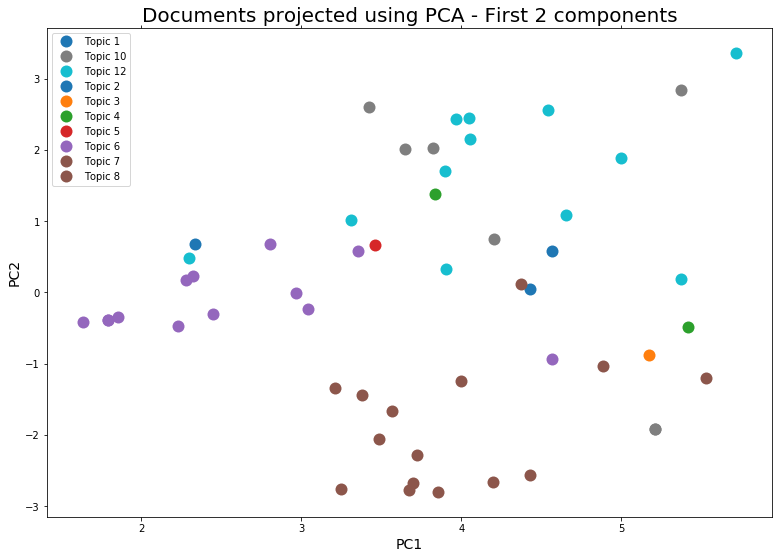

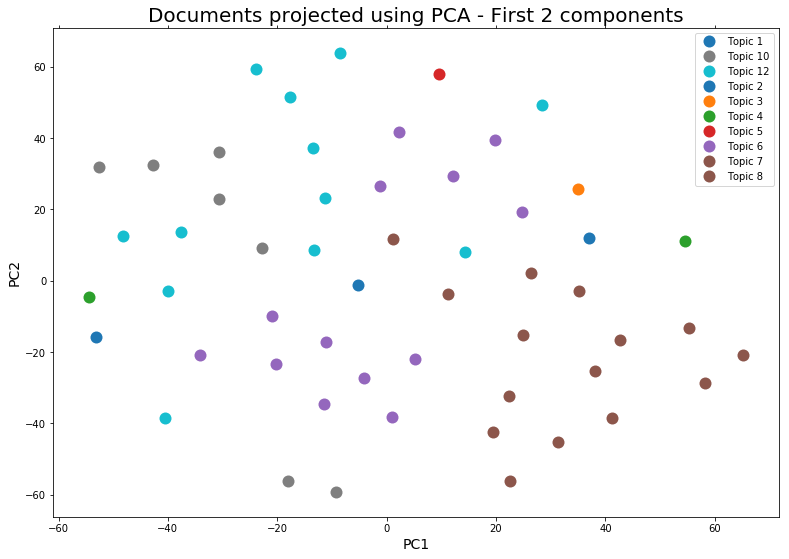

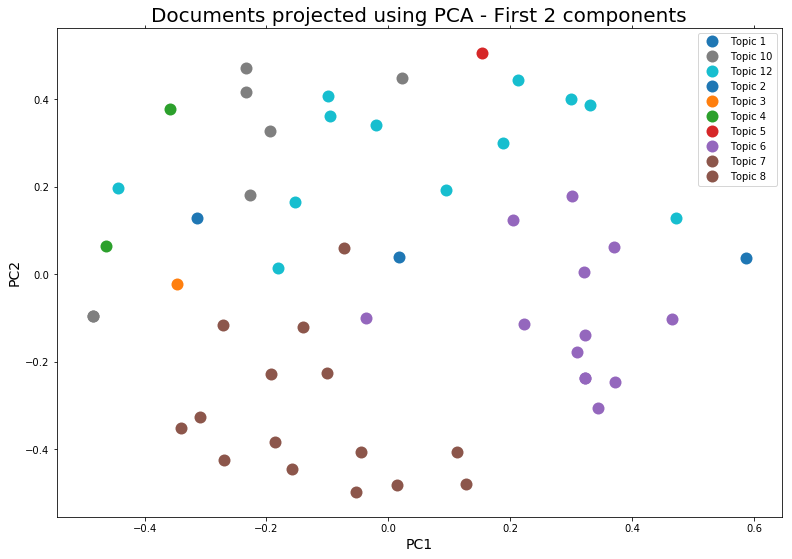

(54, 12)
(54, 54)


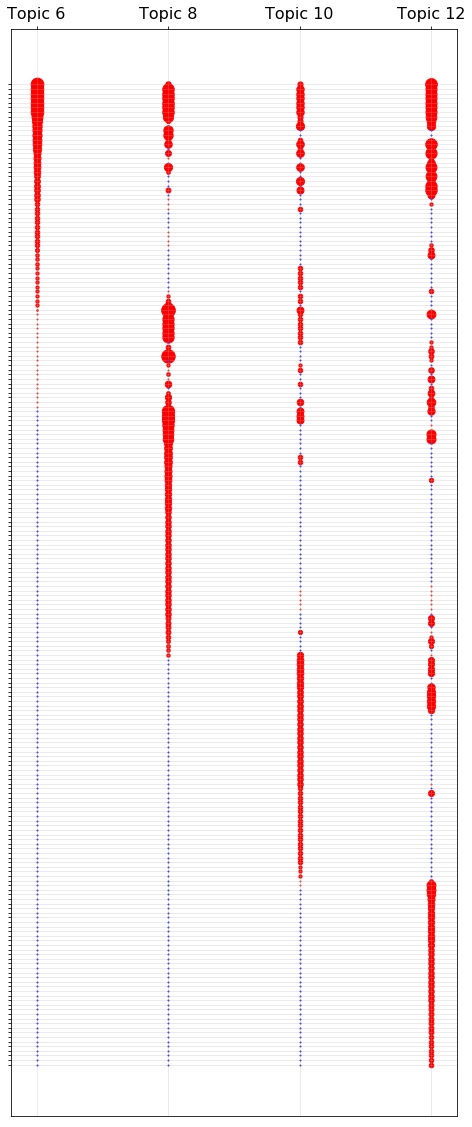

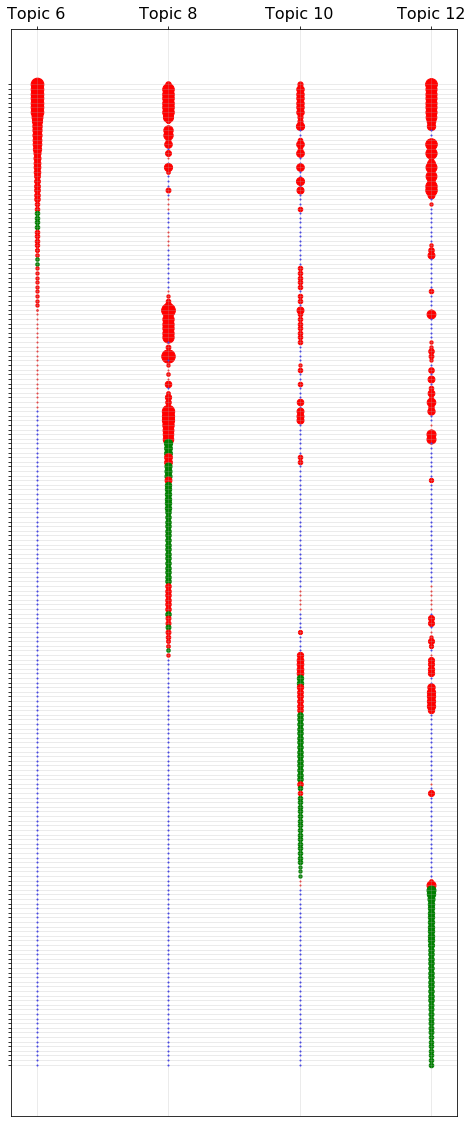

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       6.368478        1       1 -0.022341  0.109736
1       1.935966        1       2 -0.022879 -0.166731
2       4.170888        1       3  0.232916  0.055510
3       4.655772        1       4 -0.016688 -0.199473
4       3.191971        1       5 -0.055422 -0.008735
5      12.781302        1       6 -0.226602  0.094721
6       1.805723        1       7  0.016286  0.037668
7      25.873921        1       8  0.074272  0.138742
8       0.221734        1       9  0.067090 -0.037961
9      14.130031        1      10  0.006686 -0.005679
10      0.221734        1      11  0.067090 -0.037961
11     24.642480        1      12 -0.120410  0.020162, topic_info=     Category       Freq                            Term      Total  loglift  \
term                                                                           
156   Default  25.000000                     is_op_logic  25.000000  30.0000   
37    Default  30.000000                              if  30.000000  29.0000   
162   Default  23.000000                       is_string  23.000000  28.0000   
109   Default  21.000000                    is_indent if  21.000000  27.0000   
70    Default  21.000000           is_block is_indent if  21.000000  26.0000   
115   Default  17.000000                is_indent return  17.000000  25.0000   
73    Default  17.000000       is_block is_indent return  17.000000  24.0000   
146   Default  36.000000                      is_op_arit  36.000000  23.0000   
15    Default  50.000000                             def  50.000000  22.0000   
67    Default  50.000000              is_block is_indent  50.000000  21.0000   
104   Default  50.000000                       is_indent  50.000000  20.0000   
201   Default  50.000000                          return  50.000000  19.0000   
66    Default  50.000000                        is_block  50.000000  18.0000   
87    Default  50.000000                       is_dedent  50.000000  17.0000   
208   Default  10.000000                return is_string  10.000000  16.0000   
90    Default  16.000000                  is_dedent else  16.000000  15.0000   
20    Default  16.000000                            else  16.000000  14.0000   
22    Default  16.000000         else is_block is_indent  16.000000  13.0000   
21    Default  16.000000                   else is_block  16.000000  12.0000   
91    Default  16.000000         is_dedent else is_block  16.000000  11.0000   
157   Default  15.000000           is_op_logic is_number  15.000000  10.0000   
79    Default  19.000000                        is_class  19.000000   9.0000   
159   Default  14.000000  is_op_logic is_number is_block  14.000000   8.0000   
88    Default  13.000000                  is_dedent elif  13.000000   7.0000   
18    Default  13.000000                            elif  13.000000   6.0000   
168   Default   8.000000              is_string is_class   8.000000   5.0000   
97    Default  27.000000                is_dedent return  27.000000   4.0000   
94    Default  28.000000             is_dedent is_dedent  28.000000   3.0000   
121   Default  26.000000                         is_list  26.000000   2.0000   
150   Default  24.000000            is_op_arit is_number  24.000000   1.0000   
...       ...        ...                             ...        ...      ...   
46    Topic12  11.116767                        in range  14.822354   1.1130   
188   Topic12   4.055043                          number   6.288366   0.9620   
26    Topic12   6.475263                           for i  10.161284   0.9501   
31    Topic12   6.475262                            i in  10.161284   0.9501   
27    Topic12   6.475261                        for i in  10.161284   0.9501   
30    Topic12   6.475261                               i  11.031018   0.8680   
97    Topic12  12.375510                is_dedent return  27.307465   0.6093   
2

In [14]:
# Get experiment conditions
exp_id = 26
where_items = get_where_items(exp_id)
print("Conditions")
print(where_items[0][0:7])

clustering, method, feature_names, model = analyze(solutions, where_items, exp_id)
print("Number of terms: %d" % clustering.X.shape[1])
sample, y = plot_reduction(clustering, method, exp_id)
pdf(sample, y, clustering, method, exp_id)
# plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(10,22))
plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(8,20), topics=[5,7,9,11], cutoff=True, ylabel=False)
plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(8,20), topics=[5,7,9,11], cutoff=True, 
                     ylabel=False, mark_exclusive=True)
panel = LDAvis(solutions, where_items, model, R=30)
panel

# Experiment 24

- Min DF: 0.05
- Binary: True
- Vectorizer: Count
- Method: NMF
- Best k: 15

Conditions
('CountVectorizer', 0.05, True, 'euclidean', 'nmf', 'solution_all', 15)


/home/lmoraes/miniconda/envs/machine_teaching/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator NMF from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


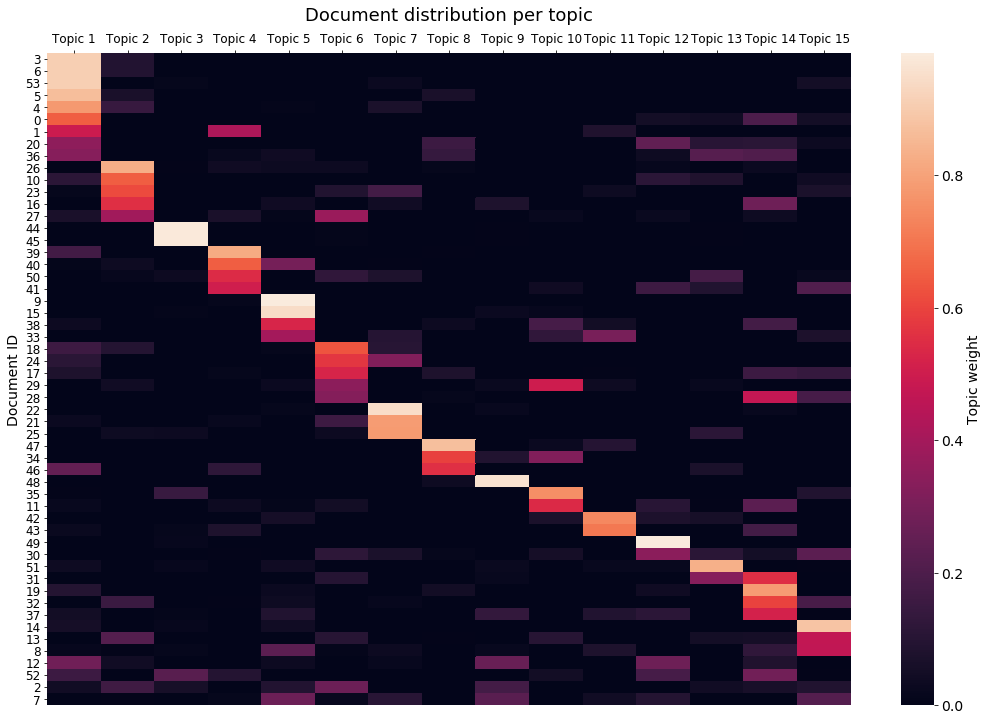

Count per class:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([10,  5,  2,  4,  5,  4,  3,  3,  1,  3,  2,  2,  1,  6,  3]))


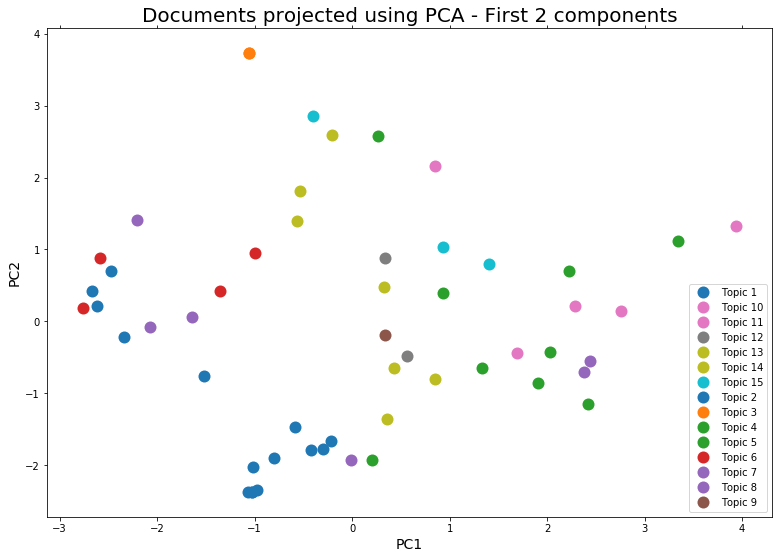

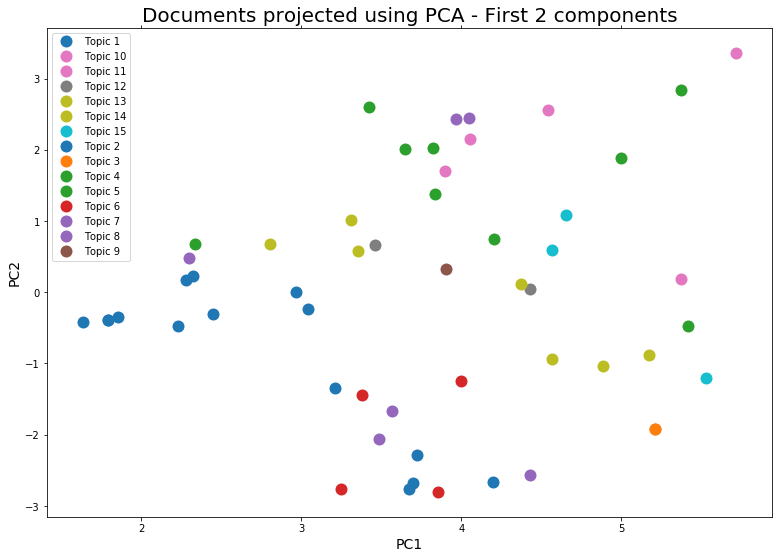

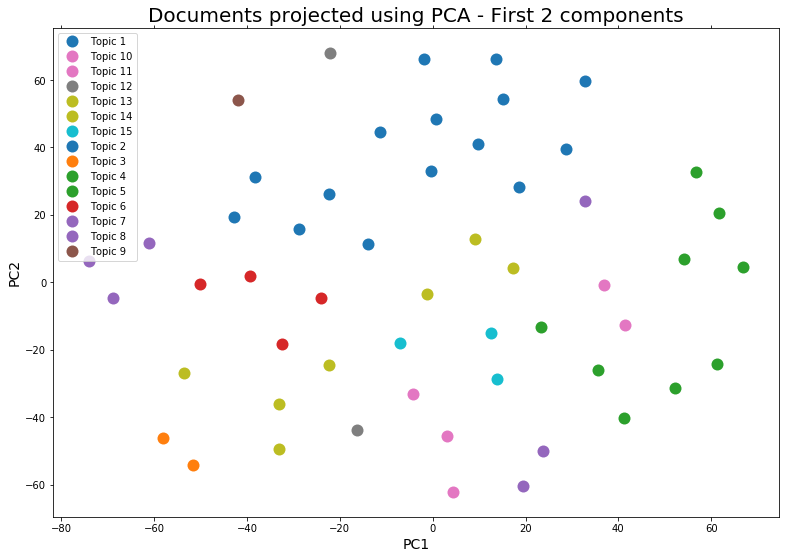

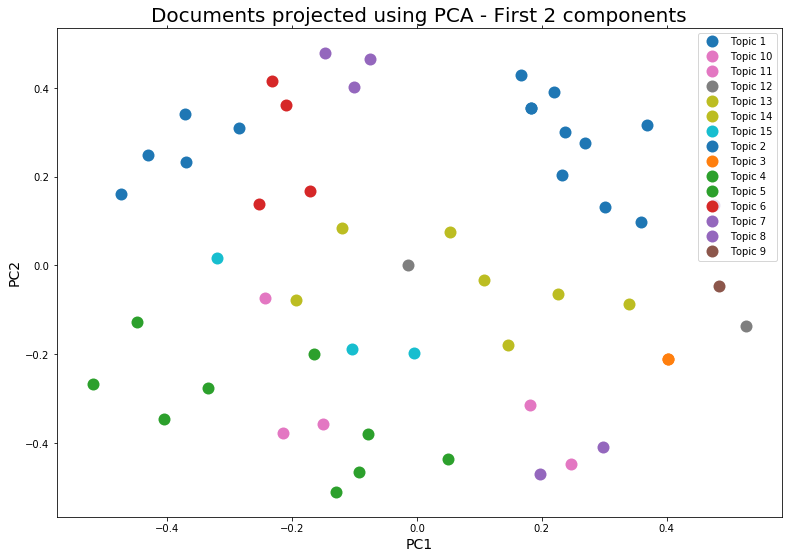

(54, 15)
(54, 54)


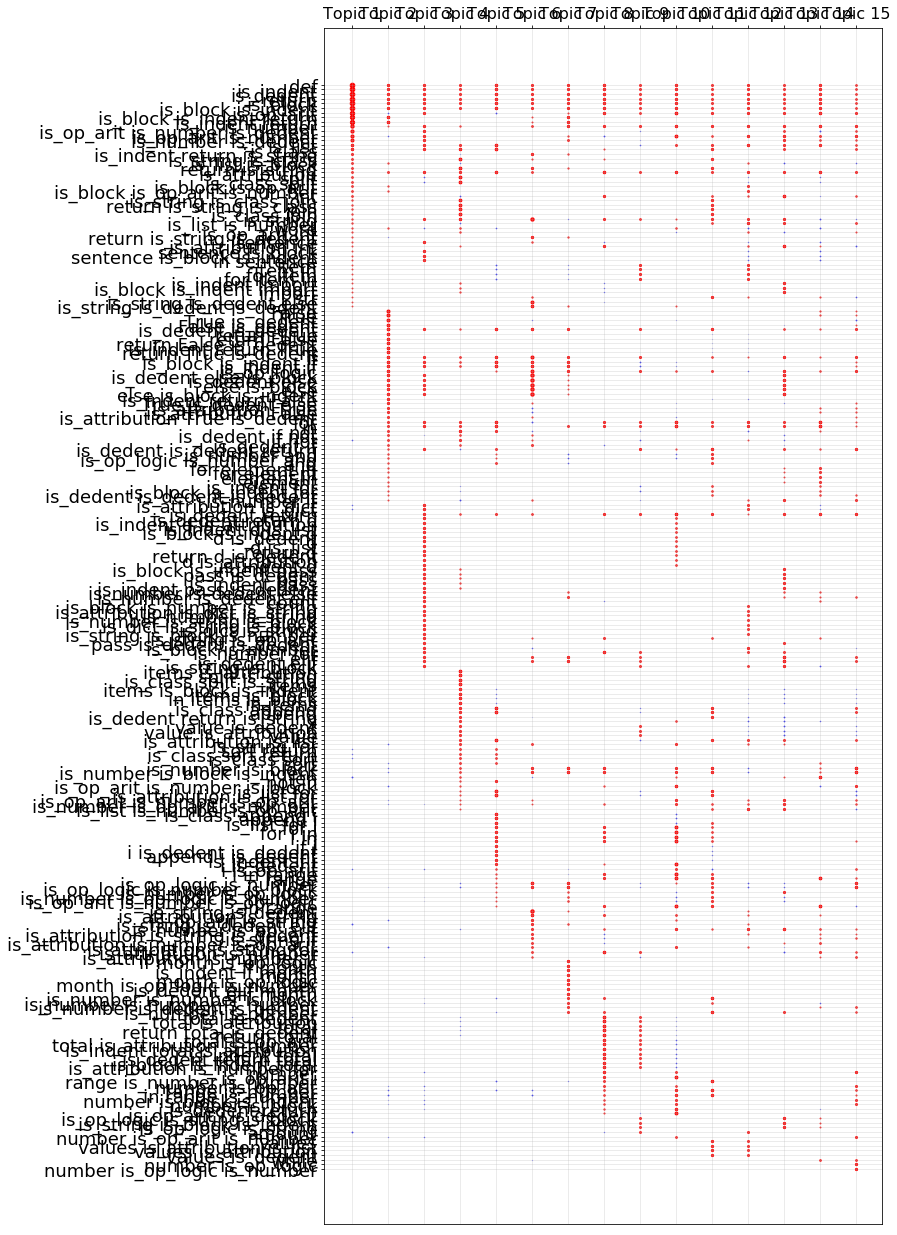

/home/lmoraes/miniconda/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/lmoraes/miniconda/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/lmoraes/miniconda/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
0      6.674680        1       1  0.031915  0.053358
1      7.639325        1       2  0.236477 -0.071601
2      7.840320        1       3  0.099138  0.172218
3      7.363359        1       4 -0.030278 -0.128014
4      8.213712        1       5 -0.090945 -0.183233
5      7.581845        1       6  0.217787 -0.048039
6      7.095033        1       7  0.182521 -0.102864
7      4.715548        1       8 -0.226287  0.047919
8      3.910237        1       9 -0.051426  0.144247
9      6.410015        1      10 -0.197340 -0.011566
10     6.043423        1      11 -0.136357 -0.163920
11     5.185293        1      12 -0.052469  0.180823
12     5.400781        1      13  0.091128  0.121343
13     8.200666        1      14 -0.048379  0.059495
14     7.725765        1      15 -0.025486 -0.070166, topic_info=Empty DataFrame
Columns: [Category, Freq, Term, Total, loglift, logprob]
Index: [], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=0, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [13]:
# Get experiment conditions
exp_id = 24
where_items = get_where_items(exp_id)
print("Conditions")
print(where_items[0][0:7])

clustering, method, feature_names, model = analyze(solutions, where_items, exp_id)
sample, y = plot_reduction(clustering, method, exp_id)
pdf(sample, y, clustering, method, exp_id)
plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(10,22))
# plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(10,60), topics=[2,5,7,9,11], cutoff=True)
panel = LDAvis(solutions, where_items, model)
panel